In [192]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE
import umap


In [194]:

# Load the dataset
file_path = '/Users/mary/Downloads/data cleannnn.csv'  # Ensure this file is in the same directory as the notebook
data = pd.read_csv(file_path)
data.head()


,ID,Continent of Origin,Country of Origin,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Total Cup Points/60,Overall,Color,Altitude
0,0,Americas,Colombia,Other,8.58,8.50,8.42,8.58,8.25,8.42,50.75,8.58,Multicolored,High Altitude (1600-2000m)
1,1,Asia,Taiwan,Washed / Wet,8.50,8.50,7.92,8.00,7.92,8.25,49.09,8.50,Multicolored,Medium Altitude (1200-1600m)
2,2,Asia,Laos,Other,8.33,8.42,8.08,8.17,7.92,8.17,49.09,8.33,Yellow,Medium Altitude (1200-1600m)
3,3,Americas,Costa Rica,Washed / Wet,8.08,8.17,8.17,8.25,8.17,8.08,48.92,8.25,Multicolored,High Altitude (1600-2000m)
4,4,Americas,Colombia,Other,8.33,8.33,8.08,8.25,7.92,7.92,48.83,8.25,Multicolored,High Altitude (1600-2000m)


In [196]:

# Select relevant numerical features (sensory attributes + total cup points) for clustering
selected_columns = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 
    'Body', 'Balance'
]
data_numeric = data[selected_columns].dropna()  # Drop rows with missing values in selected columns
data_numeric.head()


,Aroma,Flavor,Aftertaste,Acidity,Body,Balance
0,8.58,8.50,8.42,8.58,8.25,8.42
1,8.50,8.50,7.92,8.00,7.92,8.25
2,8.33,8.42,8.08,8.17,7.92,8.17
3,8.08,8.17,8.17,8.25,8.17,8.08
4,8.33,8.33,8.08,8.25,7.92,7.92


In [198]:

# Standardizing the selected numerical features for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)


In [200]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

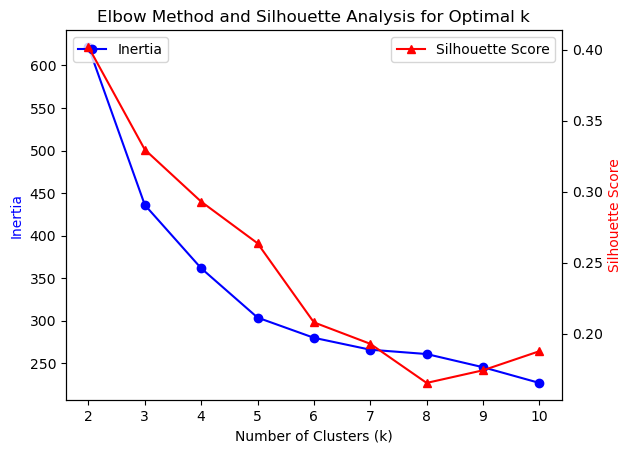

In [202]:

# Using both the elbow method and silhouette score to determine the optimal number of clusters
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plotting Elbow Curve and Silhouette Scores
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(cluster_range, inertia, 'bo-', label='Inertia')
ax2.plot(cluster_range, silhouette_scores, 'r^-', label='Silhouette Score')

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Elbow Method and Silhouette Analysis for Optimal k')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [203]:

# Based on the elbow plot, we will use k = 3 and k = 4 as the number of clusters

# --- KMeans Analysis for k=3 ---

# Initialize and fit KMeans with k=3
k_3 = 3
kmeans = KMeans(n_clusters=k_3, random_state=0)
cluster_labels = kmeans.fit_predict(data_scaled)
data_numeric['Cluster'] = cluster_labels


# --- KMeans Analysis for k=4 ---

# Initialize and fit KMeans with k=4
k_4 = 4
kmeans_4 = KMeans(n_clusters=k_4, random_state=0)
cluster_labels_4 = kmeans_4.fit_predict(data_scaled)
data_numeric['Cluster_k4'] = cluster_labels_4  # Add cluster labels to the dataset


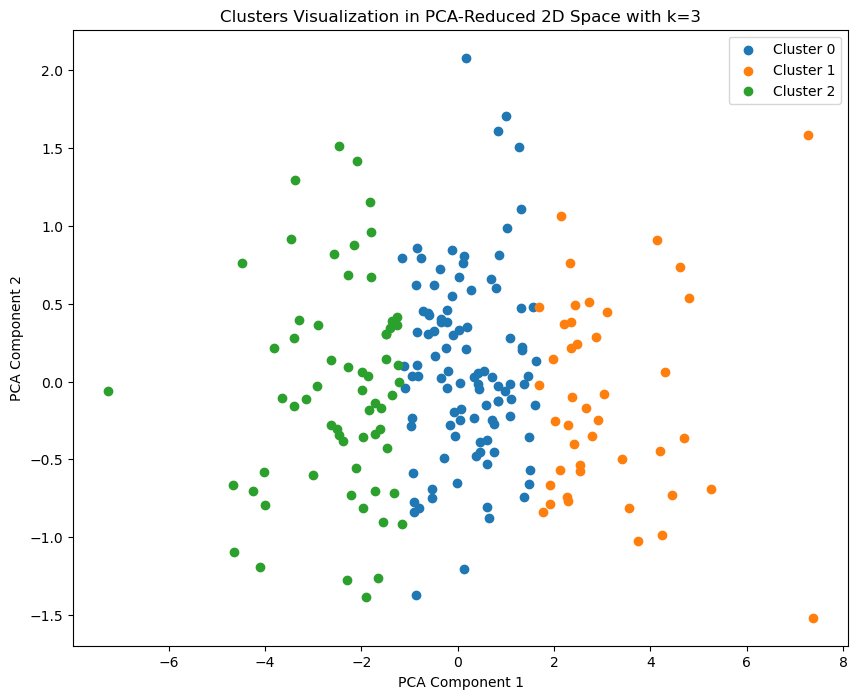

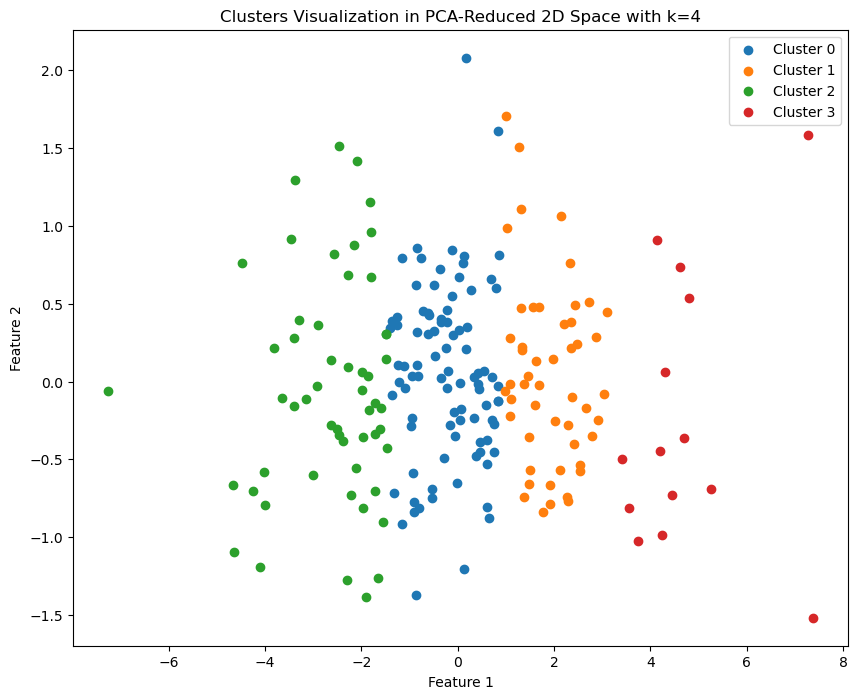

In [206]:
# --- KMeans Analysis for k=3 ---
# Using PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Plotting the PCA-reduced data with cluster labels
plt.figure(figsize=(10, 8))
for i in range(k_3):
    plt.scatter(data_pca[cluster_labels == i, 0], data_pca[cluster_labels == i, 1], label=f'Cluster {i}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization in PCA-Reduced 2D Space with k=3')
plt.legend()
plt.show()


# --- KMeans Analysis for k=4 ---
# Using PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Plotting the PCA-reduced data with cluster labels
plt.figure(figsize=(10, 8))
for i in range(k_4):
    plt.scatter(data_pca[cluster_labels_4 == i, 0], data_pca[cluster_labels_4 == i, 1], label=f'Cluster {i}')
plt.title('Clusters Visualization in PCA-Reduced 2D Space with k=4')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# The above code initializes KMeans with 4 clusters and assigns the resulting cluster labels to a new column in data_numeric.


In [207]:

# Identifying the outlier in Cluster 2 with the highest PCA Component 1 value
data_numeric[['PCA1', 'PCA2']] = data_pca
cluster_2_data = data_numeric[data_numeric['Cluster'] == 2]
outlier = cluster_2_data.loc[cluster_2_data['PCA1'].idxmax()]

# Displaying detailed feature values of the outlier
outlier_details = outlier[selected_columns]
outlier_details


Aroma         8.17
Flavor        7.83
Aftertaste    7.67
Acidity       7.83
Body          7.67
Balance       7.67
Name: 63, dtype: float64

In [210]:
def plot_voronoi_diagram(k, data_pca):
    # Fit KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_pca)
    centroids = kmeans.cluster_centers_
    cluster_labels = kmeans.predict(data_pca)

    # Generate a mesh grid for the background color regions
    x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
    y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predict the cluster for each point in the mesh
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Define colors for background regions
    colors = ['#caf0f8', '#edede9', '#48cae4', '#ffef9f']
    cmap_background = ListedColormap(colors[:k])  # Select colors based on k

    # Plot the decision boundaries and clusters
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.5)

    # Scatter plot of the data points
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis', s=30, edgecolor='k')
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', edgecolor='white', linewidth=2, label='Centroids')

    # Label and styling
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Voronoi Diagram for KMeans Clustering with k={k} in PCA-Reduced Space')
    plt.legend()
    plt.show()


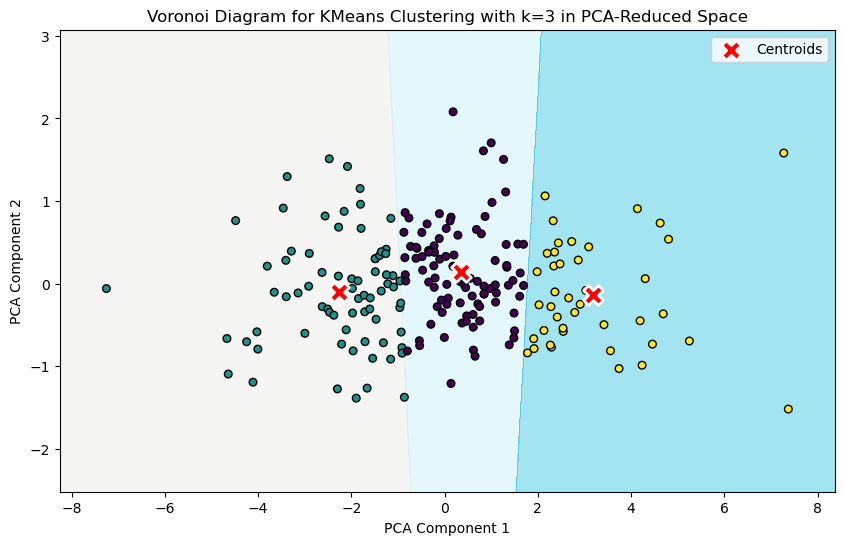

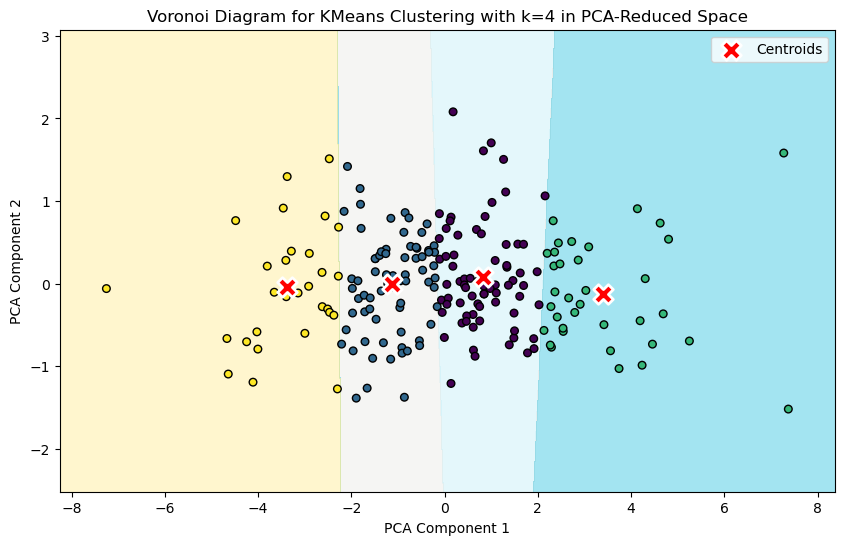

In [212]:
# Plot for k=3
plot_voronoi_diagram(3, data_pca)

# Plot for k=4
plot_voronoi_diagram(4, data_pca)


In [213]:
def plot_tsne_clusters(data, k):
    """
    Plots t-SNE clusters with KMeans centroids and convex hulls.
    
    Parameters:
    - data: numpy array or pandas DataFrame, preprocessed data to be reduced with t-SNE.
    - k: int, number of clusters for KMeans.
    """
    # Reduce data to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    data_tsne = tsne.fit_transform(data)

    # Fit KMeans on the t-SNE-transformed data with specified k
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(data_tsne)
    centroids = kmeans.cluster_centers_

    # Plot t-SNE clusters with centroids
    plt.figure(figsize=(10, 10))
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

    # Draw convex hulls around each cluster for boundary-like effect
    for i in range(k):
        points = data_tsne[cluster_labels == i]
        hull = ConvexHull(points)
        plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'k-', lw=2)

    # Labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Cluster Visualization for k={k} with Convex Hulls')
    plt.legend()
    plt.show()

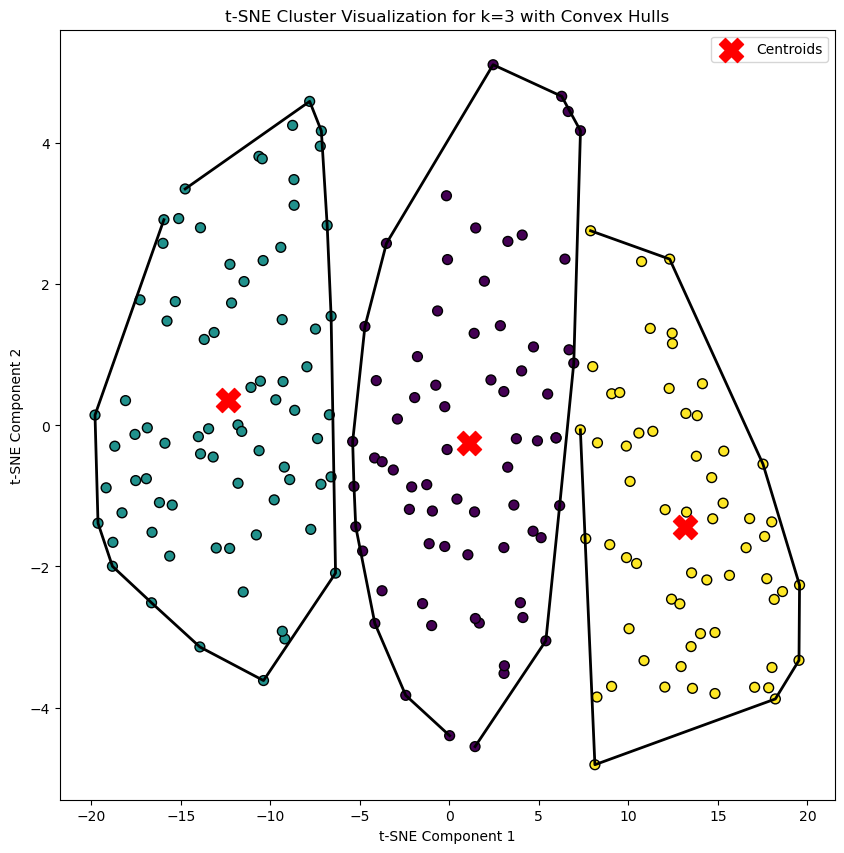

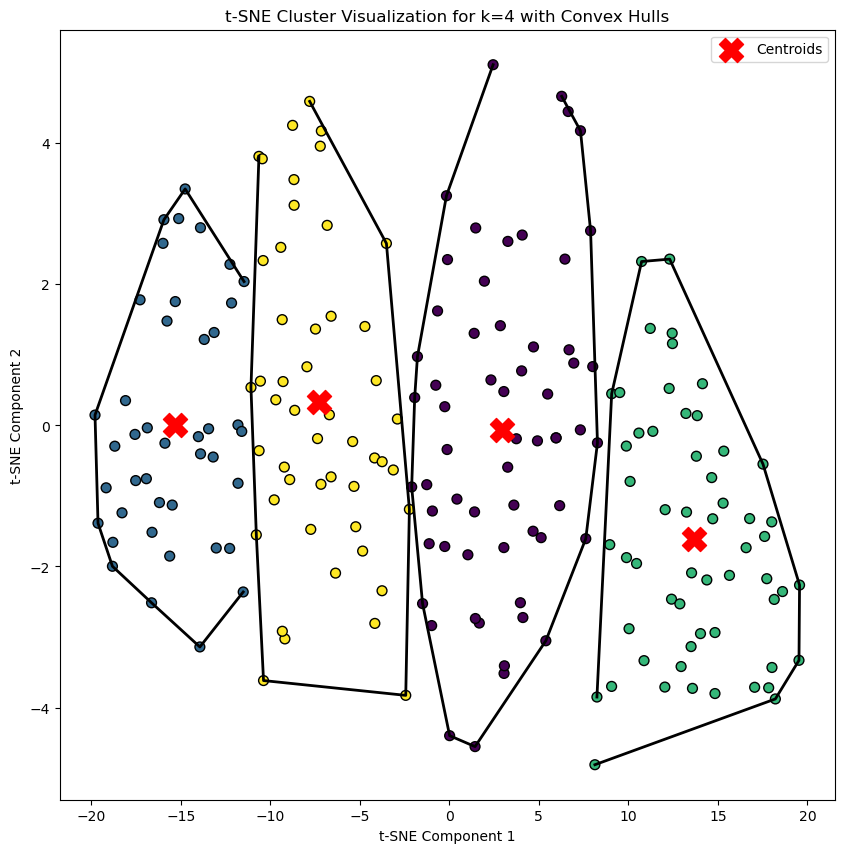

In [216]:
plot_tsne_clusters(data_scaled, k=3)  # For k=3
plot_tsne_clusters(data_scaled, k=4)  # For k=4

In [217]:
def plot_umap_decision_boundaries(data, k):
    """
    Reduces data to 2D using UMAP, applies KMeans clustering, and plots decision boundaries.
    
    Parameters:
    - data: numpy array or pandas DataFrame, preprocessed data to be reduced with UMAP.
    - k: int, number of clusters for KMeans.
    """
    # Step 1: Apply UMAP for 2D dimensionality reduction
    umap_reducer = umap.UMAP(n_components=2, random_state=0)
    data_umap = umap_reducer.fit_transform(data).astype(np.float64)  # Convert to float64

    # Step 2: Fit KMeans on the UMAP-reduced data with specified k
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(data_umap)
    centroids = kmeans.cluster_centers_

    # Step 3: Create a mesh grid for plotting decision boundaries based on UMAP data range
    x_min, x_max = data_umap[:, 0].min() - 1, data_umap[:, 0].max() + 1
    y_min, y_max = data_umap[:, 1].min() - 1, data_umap[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Ensure mesh grid is in float64 format
    mesh_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

    # Predict the cluster for each point on the grid
    Z = kmeans.predict(mesh_points).reshape(xx.shape)

    # Step 4: Plot decision boundaries, clusters, and centroids
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap='Pastel2', alpha=0.3)
    plt.scatter(data_umap[:, 0], data_umap[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

    # Label and title
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title(f'UMAP-Based Decision Boundaries for k={k}')
    plt.legend()
    plt.show()



/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


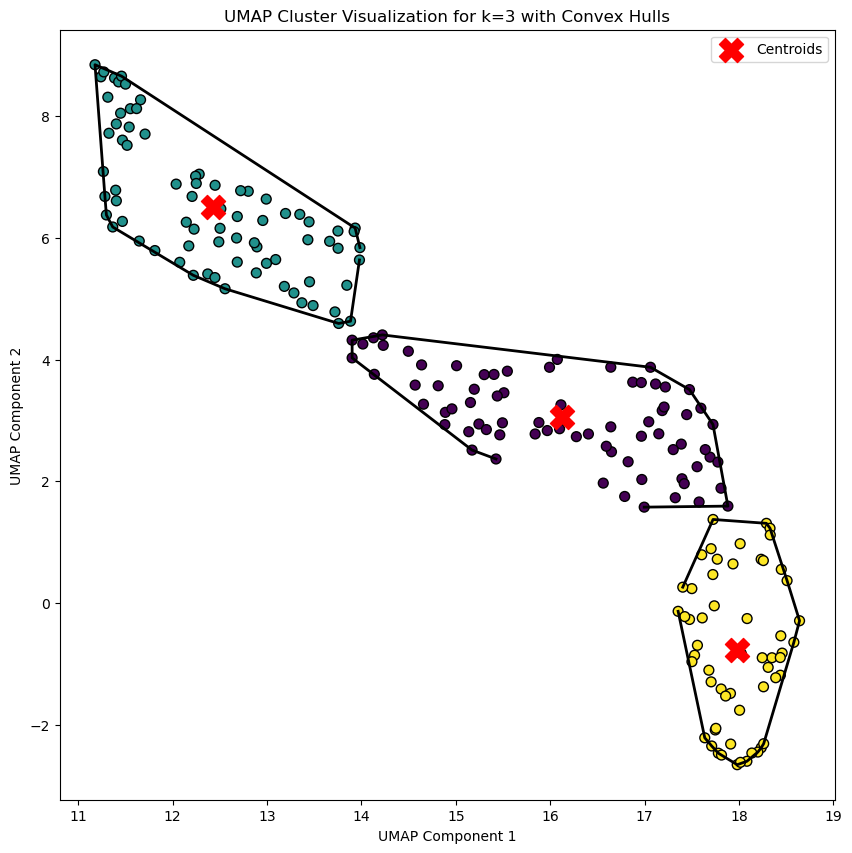

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


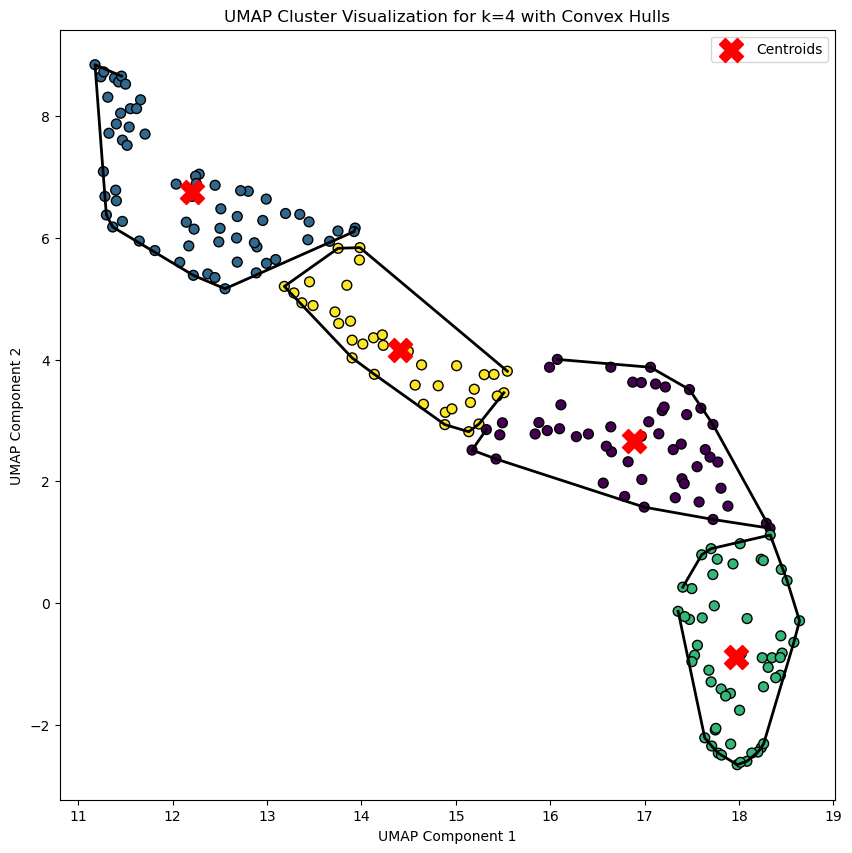

In [218]:
plot_umap_decision_boundaries(data_scaled, k=3)  # For k=3
plot_umap_decision_boundaries(data_scaled, k=4)  # For k=4

In [219]:
# Calculate mean feature values for each cluster when k=3
cluster_means = data_numeric.groupby('Cluster').mean()
cluster_means


,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Cluster_k4,PCA1,PCA2
Cluster,,,,,,,,,
0,7.683960,7.726337,7.561584,7.672574,7.640198,7.621881,0.207921,0.202150,0.088841
1,7.388140,7.370930,7.265814,7.354884,7.335116,7.304651,1.651163,3.122965,-0.122312
2,8.007778,8.029365,7.888889,7.947619,7.850794,7.911270,1.714286,-2.455630,-0.058944


In [220]:
# Calculate the mean feature values for each cluster when k=4
mean_values_k4 = data_numeric.groupby('Cluster_k4').mean()
mean_values_k4

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Cluster,PCA1,PCA2
Cluster_k4,,,,,,,,,
0,7.731236,7.780449,7.612135,7.713371,7.667640,7.669101,0.202247,-0.208767,0.052246
1,7.500200,7.505200,7.388600,7.484000,7.476200,7.443600,0.580000,1.913509,0.044356
2,8.030741,8.052778,7.916296,7.968148,7.869074,7.925926,2.000000,-2.650963,-0.066916
3,7.250714,7.185000,7.054286,7.208571,7.179286,7.113571,1.000000,4.718348,-0.232450
